In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using the data in the link below, attempt to model a customer’s propensity to join our loyalty program.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv')

In [3]:
data.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


## Exploring the Data and Inspecting Distribution

In [4]:
data.dtypes

Unnamed: 0                 int64
purch_amt                float64
gender                    object
card_on_file              object
age                      float64
days_since_last_purch    float64
loyalty                     bool
dtype: object

In [5]:
data.describe()

,Unnamed: 0,purch_amt,age,days_since_last_purch
count,120000.000000,120000.000000,120000.000000,120000.000000
mean,59999.500000,44.036234,25.803008,56.605908
std,34641.160489,20.473148,10.153072,16.422187
min,0.000000,-43.950000,-22.000000,-9.000000
25%,29999.750000,30.210000,19.000000,45.000000
50%,59999.500000,43.970000,26.000000,57.000000
75%,89999.250000,57.830000,33.000000,68.000000
max,119999.000000,142.200000,71.000000,125.000000


In [6]:
#Before I go any further I want to check in there are any null values in my dataset
print(data.isnull().sum())

Unnamed: 0               0
purch_amt                0
gender                   0
card_on_file             0
age                      0
days_since_last_purch    0
loyalty                  0
dtype: int64


In [7]:
for each in data.columns:
    print(len(data[each].unique()))

120000
11007
2
2
86
128
2


In [8]:
dataset = data.loc[:, ['loyalty','purch_amt','age','days_since_last_purch', 'gender', 'card_on_file']] 

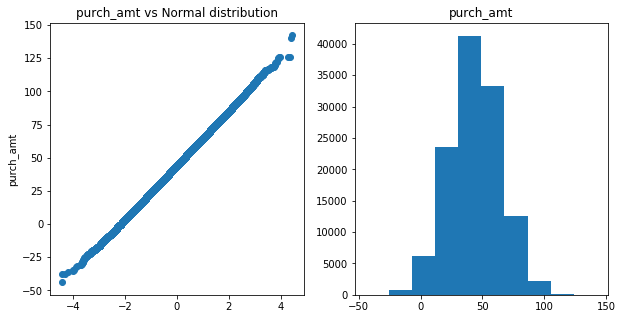

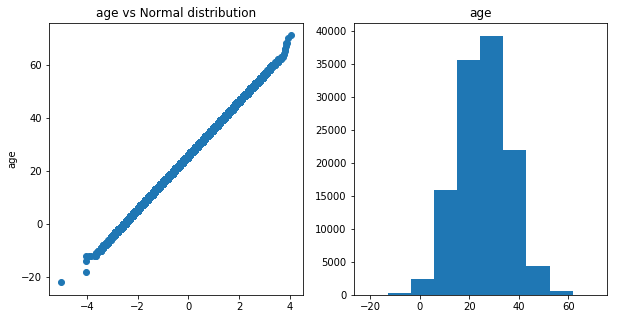

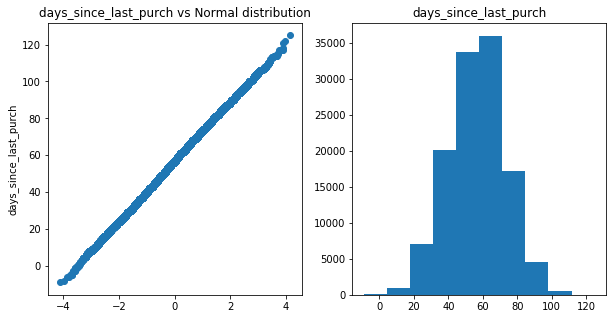

In [9]:
for item in dataset.columns:
    #I start by selecting the columns with more than 10 unique values.
    if len(dataset[item].unique()) > 10:

        #Set up the figure size
        f, ax = plt.subplots(figsize=(10, 5))
        plt.subplot(1, 2, 1)

        #Sort the values from the dataset
        result = dataset[item].sort_values()
        #Create a normal distribution variable
        norm = np.random.normal(0, 1, 120000)
        #Sort the values of the normal distribution
        norm.sort()
        #Create the QQ plot
        plt.plot(norm, result, "o")
        plt.ylabel(item)
        plt.title(item + ' vs Normal distribution')

        #Create the histogram of the dataset
        plt.subplot(1, 2, 2)
        plt.hist(result)
        plt.title(item)

In [10]:
#Next I isolate only the continuous variables so that I can visualize any correlation. 
continuous = dataset.loc[:, ['purch_amt','age','days_since_last_purch']]

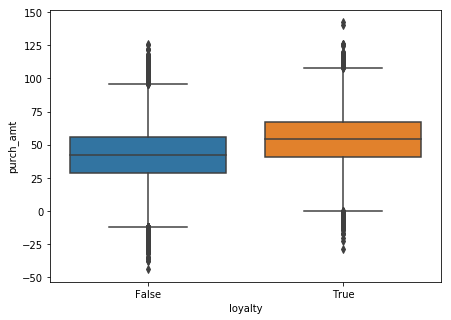

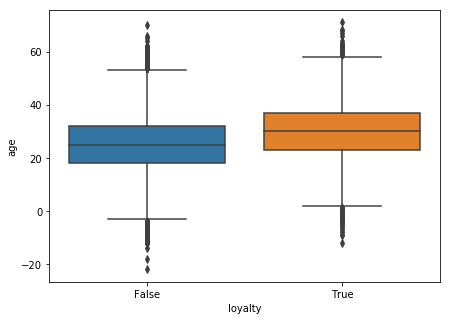

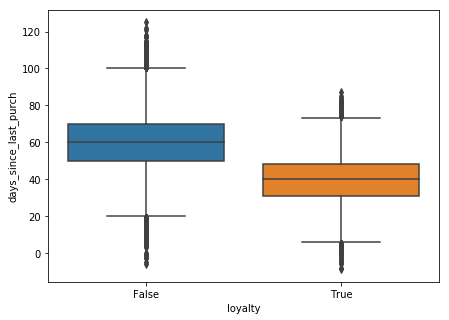

In [11]:
#This is a boxplot that compares each of the continuous variables to the loyalty level. 
for item in continuous.columns:
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.boxplot(x=dataset.loyalty, y=continuous[item])

In [12]:
categories = dataset.loc[:, ['gender','card_on_file']]

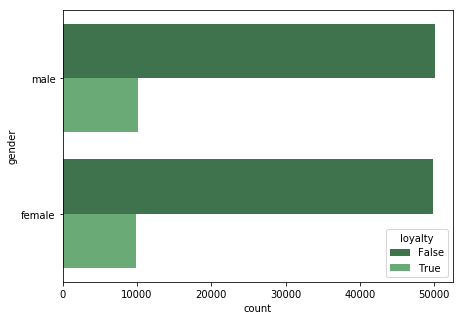

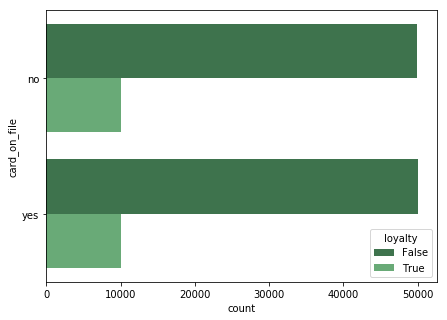

In [13]:
#This is a boxplot that compares each of the continuous variables to the loyalty level. 
for item in categories.columns:
    f, ax = plt.subplots(figsize=(7, 5))
    # Plot counts for each combination of levels.
    sns.countplot(y=categories[item], hue="loyalty", data=dataset, palette="Greens_d")
    plt.show()

In [14]:
for each in np.unique(dataset['loyalty']):
    print("loyalty {}".format(each))
    print("{}%".format(round((len(dataset[dataset['loyalty']==each])/len(dataset))*100)))

loyalty False
83%
loyalty True
17%


## Balanced Dataset

Because I am being asked to focus on predicting customer loyalty rather than disloyalty, I want To correct for the fact that my dataset has an over representation of unloyal customers. To fix this, I am going to over-sample the loyal subset.

In [15]:
# This is the size of the loyal customers in the dataset
sample_size = sum(dataset.loyalty == True)
print(sample_size)

20000


In [16]:
# Here I am selecting the index of all the unloyal customers
unloyal_indices = dataset[dataset.loyalty == False].index
# Now I am randomly selecting a sample of these unloyal customers that is the same size as the loyal group. 
random_indices = np.random.choice(unloyal_indices, sample_size, replace=False)
# Lastly, I am forming a dataset with these randomly selected unloyal customers.
unloyal_sample = dataset.loc[random_indices]

In [17]:
print(unloyal_sample.shape)
unloyal_sample.head()

(20000, 6)


,loyalty,purch_amt,age,days_since_last_purch,gender,card_on_file
4090,False,22.36,24.0,46.0,female,yes
100655,False,34.78,8.0,82.0,male,yes
117203,False,45.84,38.0,60.0,male,yes
22349,False,12.67,18.0,55.0,female,yes
92209,False,36.63,34.0,79.0,female,yes


In [18]:
loyal_sample = dataset[dataset.loyalty == True]
print(loyal_sample.shape)
loyal_sample.head()

(20000, 6)


,loyalty,purch_amt,age,days_since_last_purch,gender,card_on_file
9,True,93.63,40.0,47.0,female,no
13,True,64.91,22.0,59.0,male,yes
23,True,11.55,21.0,53.0,male,no
28,True,40.64,20.0,29.0,female,no
35,True,64.07,10.0,62.0,male,no


In [19]:
sample_list = [unloyal_sample, loyal_sample]

In [20]:
balanced_data = pd.concat(sample_list)
balanced_data.index = range(len(balanced_data.index))

In [21]:
print(balanced_data.shape)
balanced_data.head()

(40000, 6)


,loyalty,purch_amt,age,days_since_last_purch,gender,card_on_file
0,False,22.36,24.0,46.0,female,yes
1,False,34.78,8.0,82.0,male,yes
2,False,45.84,38.0,60.0,male,yes
3,False,12.67,18.0,55.0,female,yes
4,False,36.63,34.0,79.0,female,yes


## Modeling

My assignment is to model a customer’s propensity to join the loyalty program rather than explaining which features are most important. Because of this, I am going to focus on creating predictive models. On top of this, my dependent outcome is a categorical feature rather than a continuous one. This means that each of my models will be a classification and not a regression model. 

In [22]:
# Defining my dependent and independent features
y = balanced_data.loyalty
x = balanced_data.drop(['loyalty'], axis=1)

#In order to use the categorical features I need use get_dummies
x = pd.get_dummies(x)

## Random Forest Classifier

In [23]:
# Random Forest Classification
rfc = ensemble.RandomForestClassifier(n_estimators=30)
rfc.fit(x, y)
print(rfc)
print('Training set score:', rfc.score(x, y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training set score: 0.9982


In [24]:
RFC_score = cross_val_score(rfc, x, y, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classification Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.758    0.762    0.76675  0.773375 0.765375]

Overall Random Forest Classification Accuracy: 0.77 (+/- 0.01)



In [25]:
print("Report:")
y_true, y_pred = y, rfc.predict(x)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

      False       1.00      1.00      1.00     20000
       True       1.00      1.00      1.00     20000

avg / total       1.00      1.00      1.00     40000



array([[19979,    21],
       [   51, 19949]])

In [26]:
# Saving the feature names
feature_list = list(x.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [27]:
feature_importances = feature_importances[:20]
importance = []
importance_name = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_name.append(each[0])

In [28]:
feature_importances

[('days_since_last_purch', 0.46),
 ('purch_amt', 0.36),
 ('age', 0.17),
 ('gender_female', 0.0),
 ('gender_male', 0.0),
 ('card_on_file_no', 0.0),
 ('card_on_file_yes', 0.0)]

## Gradient Boosting Classifier

In [29]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(loss = 'deviance', max_depth=10)
clf_model = clf.fit(x, y)
print(clf_model)
print('Training set score:', clf.score(x, y))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Training set score: 0.88425


In [30]:
CLF_score = cross_val_score(clf, x, y, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.78425  0.777625 0.782875 0.78825  0.7905  ]

Overall Gradient Boosted Classifier Accuracy: 0.78 (+/- 0.01)



In [31]:
print("Report:")
y_true, y_pred = y, clf.predict(x)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

      False       0.90      0.86      0.88     20000
       True       0.87      0.90      0.89     20000

avg / total       0.88      0.88      0.88     40000



array([[17282,  2718],
       [ 1912, 18088]])

In [32]:
# Saving the feature names
feature_list = list(x.columns)
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [33]:
feature_importances = feature_importances[:20]
importance = []
importance_name = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_name.append(each[0])

In [34]:
feature_importances

[('purch_amt', 0.45),
 ('days_since_last_purch', 0.31),
 ('age', 0.18),
 ('gender_male', 0.02),
 ('card_on_file_no', 0.02),
 ('card_on_file_yes', 0.02),
 ('gender_female', 0.01)]

## Logistic Regression

In [35]:
lr = LogisticRegression()
lf_model = lr.fit(x, y)
print(lf_model)
print('Training set score:', lr.score(x, y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training set score: 0.79635


In [36]:
LR_score = cross_val_score(lr, x, y, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated Accuracy score: 
 [0.797875 0.790625 0.79325  0.798625 0.801375]

Overall Logistic Regression Accuracy: 0.80 (+/- 0.01)



In [37]:
print("Report:")
y_true, y_pred = y, lr.predict(x)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
             precision    recall  f1-score   support

      False       0.80      0.79      0.79     20000
       True       0.79      0.80      0.80     20000

avg / total       0.80      0.80      0.80     40000



array([[15765,  4235],
       [ 3911, 16089]])

# Conclusion

From this modeling, I believe that I have several reliable models that could likely improve in accuracy with additional data and sampling. I can see that the random forest classification model has the highest precision and recall scores but also the most over fitting between the training and cross validated accuracy levels. I decided to print out the feature importance because it can provide insight into making my model and datasets more efficient. The gradient boosted classification model still had good precision and recall with a lower amount of over-fitting and slightly different feature importance. The only down side of the gradient model is that it took a longer amount of time to run and return its results. Lastly, the logistic regression model has similar precision and recall to the previous models but little to no signs of over fitting. 